# Semantic Segmentation

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers

Download the pet dataset

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

# **U_NET:**

# Preprocessing data


In [3]:
NUM_EPOCHS = 30
image_size = 128

In [4]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (image_size, image_size), method="nearest")
   input_mask = tf.image.resize(input_mask, (image_size, image_size), method="nearest")
   return input_image, input_mask

In [5]:
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask -= 1
   return input_image, input_mask

In [6]:
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [7]:
def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)

   return input_image, input_mask

In [8]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

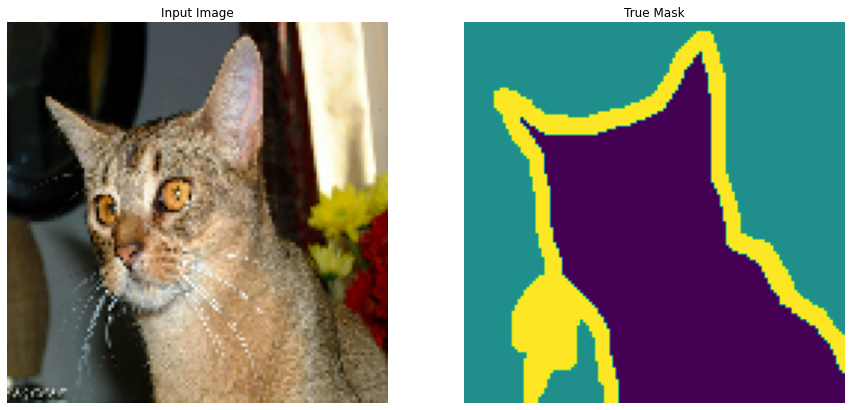

In [10]:
def display(display_list):
 plt.figure(figsize=(15, 15))

 title = ["Input Image", "True Mask", "Predicted Mask"]

 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image = sample_batch[0][random_index]
sample_mask = sample_batch[1][random_index]
display([sample_image, sample_mask])

# UNet Architecture
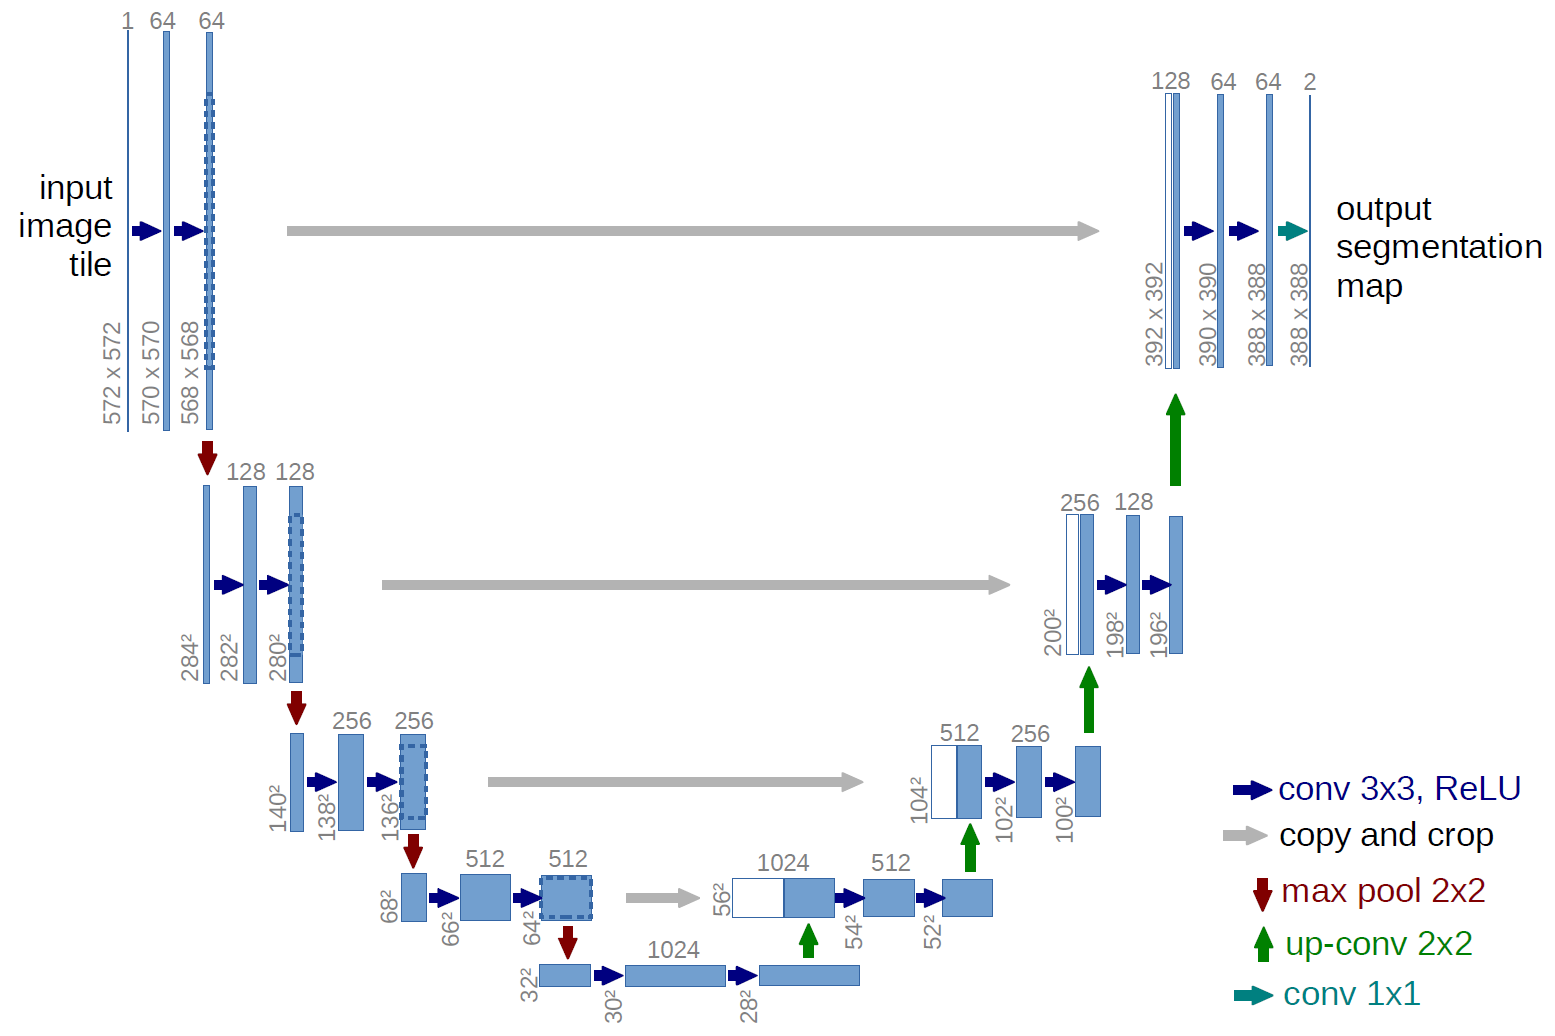



You can use the following link to get acquainted with convolution2d_transpose:


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

In this part:

1.   Design UNet Encoder-Decoder model layer by layer with Keras tool
2.   Compile your model
3.   Train model, show and plot accuracy and loss
4.   display some of predicted masks beside related true masks

Notes:

Use Adam optimizer with learning rate 0.001 and sparse_categorical_crossentropy as loss function

Set accuracy for metrics


In [11]:
# Conv2D 
def Conv(x, filters):
   x = layers.Conv2D(filters, 3, padding = "same", activation = "relu")(x)
   x = layers.Conv2D(filters, 3, padding = "same", activation = "relu")(x)
   return x

In [12]:
# Max pool
def Maxpool(x):
   p = layers.MaxPool2D(2)(x)
   p = layers.Dropout(0.3)(p)
   return p

In [13]:
# Up conv
def Up_conv(x, features, filters):

   x = layers.Conv2DTranspose(filters, 3, 2, padding="same")(x)
   x = layers.concatenate([x, features])
   x = layers.Dropout(0.3)(x)
   return x

In [14]:
# UNet MOdel
def UNet():

   inputs = layers.Input(shape=(128,128,3))

   # Encoding
   # Block 1
   Block_1 = Conv(inputs, 64)
   Pool_1 = Maxpool(Block_1)

   # Block 2
   Block_2 = Conv(Pool_1, 128)
   Pool_2 = Maxpool(Block_2)

   # Block 3
   Block_3 = Conv(Pool_2, 256)
   Pool_3 = Maxpool(Block_3)

   # Block 4
   Block_4 = Conv(Pool_3, 512)
   Pool_4 = Maxpool(Block_4)

   # Block 5
   Block_5 = Conv(Pool_4, 1024)

   # Decoding
   # Block 6
   Up_conv_1 = Up_conv(Block_5,Block_4,512)
   Block_6 = Conv(Up_conv_1, 512)

   # Block 7
   Up_conv_2 = Up_conv(Block_6,Block_3,256)
   Block_7 = Conv(Up_conv_2, 256)

   # Block 8
   Up_conv_3 = Up_conv(Block_7,Block_2,128)
   Block_8 = Conv(Up_conv_3, 128)

   # Block 9
   Up_conv_4 = Up_conv(Block_8,Block_1,64)
   Block_9 = Conv(Up_conv_4, 64)

   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(Block_9)
   model = tf.keras.Model(inputs, outputs, name="U-Net")

   return model

In [15]:
model = UNet()

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss="sparse_categorical_crossentropy",metrics="accuracy")

In [17]:
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

# Fit model
model_history = model.fit(train_batches,epochs=NUM_EPOCHS,steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS,validation_data=test_batches)

Epoch 1/30
57/57 [==============================] - 86s 1s/step - loss: 1.0640 - accuracy: 0.5807 - val_loss: 0.8637 - val_accuracy: 0.5864
Epoch 2/30
57/57 [==============================] - 72s 1s/step - loss: 0.7915 - accuracy: 0.6463 - val_loss: 0.7224 - val_accuracy: 0.7104
Epoch 3/30
57/57 [==============================] - 65s 1s/step - loss: 0.7144 - accuracy: 0.7110 - val_loss: 0.6702 - val_accuracy: 0.7262
Epoch 4/30
57/57 [==============================] - 66s 1s/step - loss: 0.6526 - accuracy: 0.7353 - val_loss: 0.6228 - val_accuracy: 0.7455
Epoch 5/30
57/57 [==============================] - 66s 1s/step - loss: 0.6264 - accuracy: 0.7467 - val_loss: 0.5764 - val_accuracy: 0.7690
Epoch 6/30
57/57 [==============================] - 66s 1s/step - loss: 0.5738 - accuracy: 0.7703 - val_loss: 0.5462 - val_accuracy: 0.7842
Epoch 7/30
57/57 [==============================] - 66s 1s/step - loss: 0.5407 - accuracy: 0.7866 - val_loss: 0.4860 - val_accuracy: 0.8093
Epoch 8/30
57/57 [==

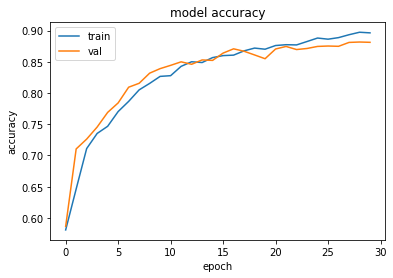

In [18]:
# Accuracy
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

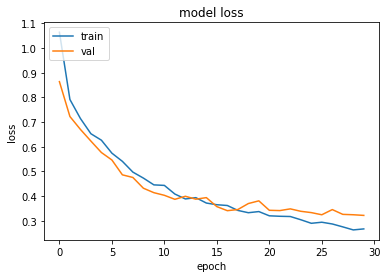

In [19]:
# Loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
# Mask
def create_mask(pred_mask):
 pred_mask = tf.argmax(pred_mask, axis=-1)
 pred_mask = pred_mask[..., tf.newaxis]
 return pred_mask[0]

1/1 [==============================] - 1s 1s/step


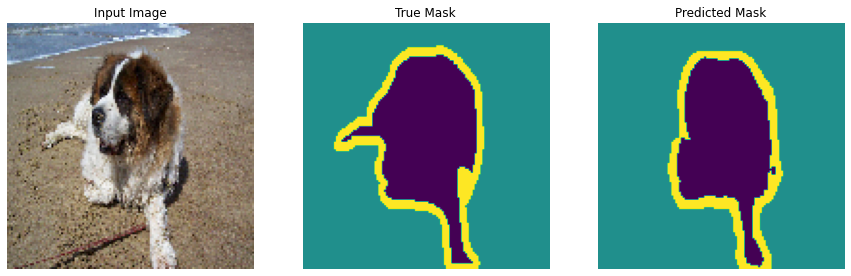

1/1 [==============================] - 0s 18ms/step


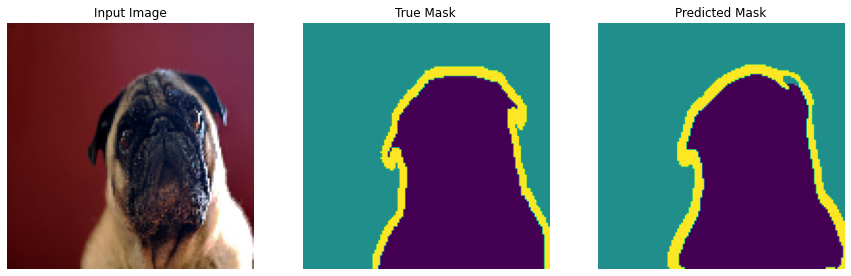

1/1 [==============================] - 0s 18ms/step


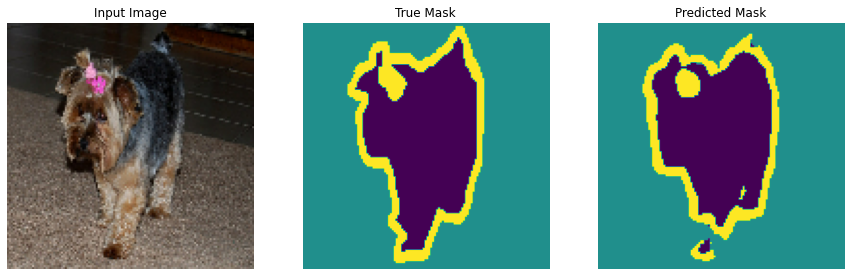

1/1 [==============================] - 0s 17ms/step


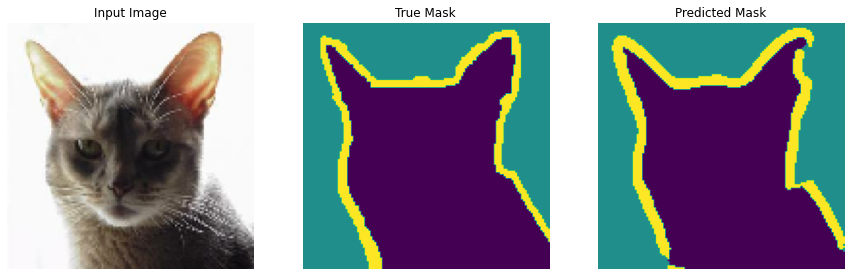

1/1 [==============================] - 0s 17ms/step


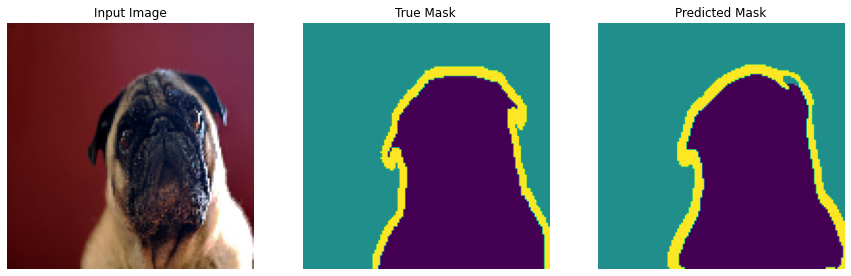

In [21]:
# Show image ,mask and predict 
sample_batch = next(iter(test_batches))

for i in range(5):
  random_index = np.random.choice(sample_batch[0].shape[0])
  sample_image = sample_batch[0][random_index]
  sample_mask = sample_batch[1][random_index]
  display([sample_image, sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])